# Импорт и обработка данных

In [ ]:
# @title Импорт библиотек
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from cycler import cycler
import json
import joblib

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# @title Импорт примера итоговых входных данных
inputDataTmp = pd.read_json(path_or_buf='./data/input.json', lines=True)
prof = pd.DataFrame.from_dict(inputDataTmp['profile'].tolist() )

# ----------------------------
prof = prof.fillna(0)
prof['birth_date'] = prof['birth_date'].astype(int)
prof.rename(columns = {'id':'profile_id'}, inplace = True )
# обработка input dataProfiles
prof['sex'] = prof['sex'] == 'male' # 0 - female, 1 - male
prof['sex'] = prof['sex'].astype(int)
prof['hr_delta'] = prof['hr_max'] -  prof['hr_rest']
del prof['hr_rest']
del prof['hr_max']
del prof['personal_goals']
# ----------------------------

inpData = pd.DataFrame.from_dict(inputDataTmp['sessions'].tolist() )

# ----------------------------
inpData = inpData.T
inpData.rename(columns = {0:'days'}, inplace = True )
inpData = pd.DataFrame.from_dict(inpData['days'].tolist() )
inpData['start_millis'] = inpData['start_millis'].astype(int)
inpData['stop_millis'] = inpData['stop_millis'].astype(int)
inpData['kkal'] = inpData['kkal'].astype(float)
inpData['activity_day'] = inpData['activity_day'].astype(int)
del inpData['timezone']
del inpData['skllzz_without_artifacts']
del inpData['skllzz_with_artifacts']
del inpData['skllzz']
del inpData['id']
inpData['delta_millis'] = inpData['stop_millis'] - inpData['start_millis']
del inpData['stop_millis']
del inpData['start_millis']
inpData = inpData.merge(prof, on='profile_id', how='inner')

inpDataSteps = pd.DataFrame.from_dict(inpData['steps'].tolist() )
del inpDataSteps['day']
del inpDataSteps['samples']
del inpData['steps']

inpData = inpData.join(inpDataSteps)
inpData = inpData.fillna(0)
# ----------------------------
inpData.head(1)

,kkal,profile_id,activity_day,delta_millis,birth_date,sex,weight,hr_delta,steps,meters
0,6.99,kKXtPktVl1ckIOuURYjkV9bsdr8wD3-ixCjVoJ9zSSA,1484,86400000,10800,0,60,136,233,184


In [ ]:
# @title Импорт профилей пользователей
dataProfiles = pd.read_json(path_or_buf='./data/profiles.jsonl', lines=True)
dataProfiles = dataProfiles.fillna(0)
dataProfiles['birth_date'] = dataProfiles['birth_date'].astype(int)
dataProfiles.rename(columns = {'id':'profile_id'}, inplace = True )

# обработка dataProfiles
dataProfiles['sex'] = dataProfiles['sex'] == 'male' # 0 - female, 1 - male
dataProfiles['sex'] = dataProfiles['sex'].astype(int)
dataProfiles['hr_delta'] = dataProfiles['hr_max'] -  dataProfiles['hr_rest']
del dataProfiles['hr_rest']
del dataProfiles['hr_max']
del dataProfiles['personal_goals']
dataProfiles.head(1)

,profile_id,birth_date,sex,weight,hr_delta
0,SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE,800,0,76.0,110


In [ ]:
# @title Импорт датасета читеров
dataCheaters = pd.read_json(path_or_buf='./data/activity_step_cheaters.jsonl', lines=True)
dataCheaters = dataCheaters.assign(cheat = 1)
dataCheaters.head(1)

,id,start_millis,stop_millis,skllzz,steps,timezone,kkal,profile_id,activity_day,skllzz_without_artifacts,skllzz_with_artifacts,active_artifacts,cheat
0,lvgV15HELbSFmYR5SeK4qp3l4HSo_yq3LVN1RjXPDi0,1690578000000,1690664400000,48.96,"{'steps': 12240, 'day': 1305, 'meters': 10190,...",Europe/Minsk,642.6,QE9POkTz-nPztlJqRen6Y5djiFUnGkzEW41umE1E9b8,1305,48.96,NaN,NaN,1


In [ ]:
# @title Импорт датасета честных пользователей
data = []
with open ('./data/activity_step_ok.jsonl', 'r') as file:
    for line in file:
      data.append(line)

x = []
for i in range(6000):
  result = json.loads(data[i])
  x.append(result)

data.clear()
dataOk = pd.DataFrame.from_dict(x)
dataOk = dataOk.assign(cheat = 0)

dataOk.loc[dataOk['profile_id'].isin(dataCheaters['profile_id']), 'cheat'] = 1
dataOk.head(1)

,id,start_millis,stop_millis,skllzz,steps,timezone,kkal,profile_id,activity_day,skllzz_without_artifacts,active_artifacts,skllzz_with_artifacts,cheat
0,ffC9QD094txzeMzKVqXHQAzx4narEGeISQYcpwtf_hM,1684515600000,1684602000000,8.036,"{'steps': 2009, 'day': 1235, 'meters': 1632, '...",Asia/Novokuznetsk,76.342,SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE,1235,8.036,NaN,NaN,0


# Создание итогового датасета

In [ ]:
# @title Слияние датасетов: читеров, честных пользователей, профилей пользователей

dataSet = pd.concat([dataOk,dataCheaters])

dataSet['start_millis'] = dataSet['start_millis'].astype(int)
dataSet['stop_millis'] = dataSet['stop_millis'].astype(int)
dataSet['kkal'] = dataSet['kkal'].astype(float)
dataSet['activity_day'] = dataSet['activity_day'].astype(int)
del dataSet['timezone']
del dataSet['skllzz_without_artifacts']
del dataSet['active_artifacts']
del dataSet['skllzz_with_artifacts']
del dataSet['skllzz']
del dataSet['id']
dataSet['delta_millis'] = dataSet['stop_millis'] - dataSet['start_millis']
del dataSet['stop_millis']
del dataSet['start_millis']
dataSet = dataSet.merge(dataProfiles, on='profile_id', how='inner')

In [ ]:
# @title Добавление информации о шагах в датасет
dfStep = pd.DataFrame.from_dict(dataSet['steps'].tolist() )
del dataSet['steps']
del dfStep['day']
del dfStep['samples']
dataSet = dataSet.join(dfStep)
dataSet = dataSet.fillna(0)

dataSet.head(1)

,kkal,profile_id,activity_day,cheat,delta_millis,birth_date,sex,weight,hr_delta,steps,meters
0,76.342,SoNAuI4y0kgDCqCd0E3ruHH-V84jY7fDJxovrTVh8pE,1235,0,86400000,800,0,76.0,110,2009.0,1632.0


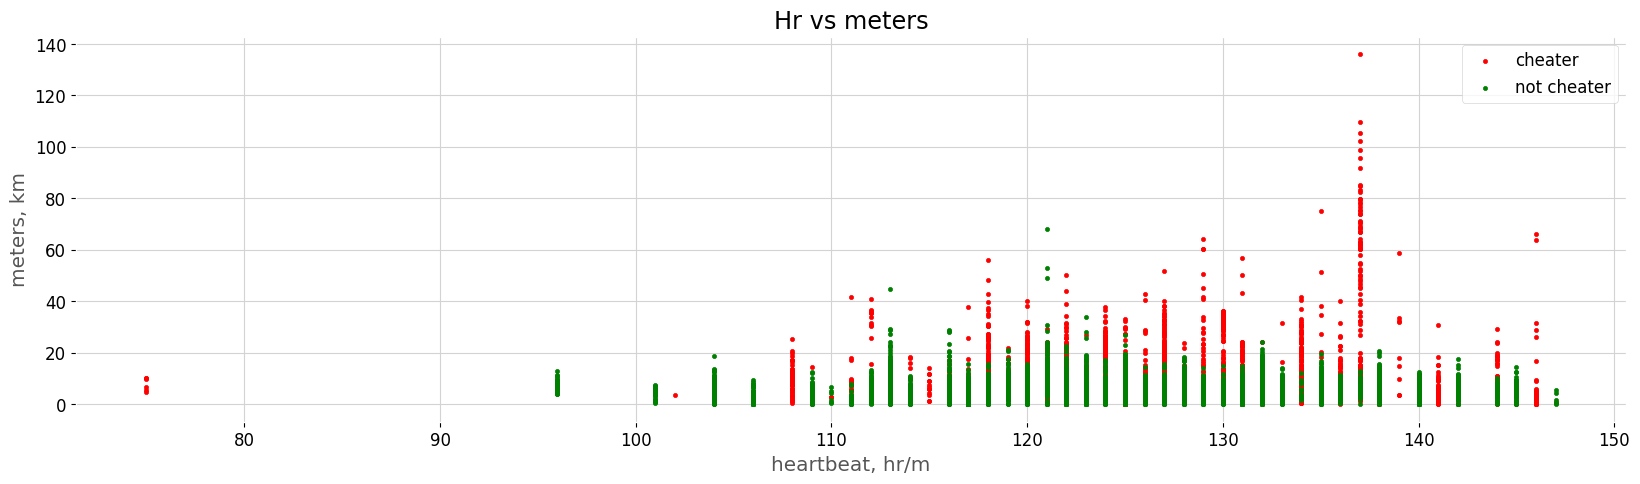

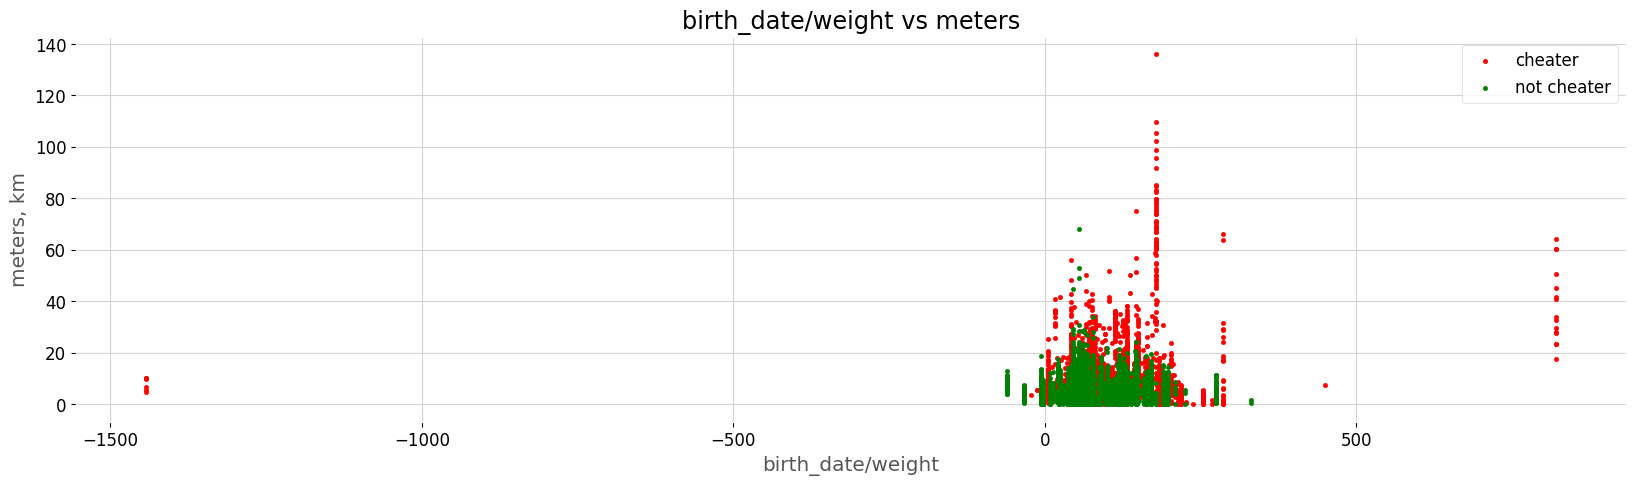

In [ ]:
# @title cheat vs delta_millis
colors = cycler(color=["#4353ff", "purple", "orange", "green"])

mpl.style.use("ggplot")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "lightgray"
mpl.rcParams["axes.prop_cycle"] = colors
mpl.rcParams["axes.linewidth"] = 1
mpl.rcParams["xtick.color"] = "black"
mpl.rcParams["ytick.color"] = "black"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

tmpCheaters = dataSet[dataSet['cheat'] == 1]
tmpNotCheaters = dataSet[dataSet['cheat'] == 0]


#---------Hr vs meters-----------
plt.scatter(tmpCheaters['hr_delta'], tmpCheaters['meters']/1000, marker='.', c='r')
plt.scatter(tmpNotCheaters['hr_delta'], tmpNotCheaters['meters']/1000, marker='.', c='green')
plt.legend (('cheater', 'not cheater'))
plt.xlabel('heartbeat, hr/m')
plt.ylabel('meters, km')
plt.title("Hr vs meters")
plt.show()

#---------birth_date/weight vs meters -----------
plt.scatter(tmpCheaters['birth_date']/tmpCheaters['weight'], tmpCheaters['meters']/1000, marker='.', c='r')
plt.scatter(tmpNotCheaters['birth_date']/tmpNotCheaters['weight'], tmpNotCheaters['meters']/1000, marker='.', c='green')
plt.legend (('cheater', 'not cheater'))
plt.xlabel('birth_date/weight')
plt.ylabel('meters, km')
plt.title("birth_date/weight vs meters")
plt.show()

# Обучение модели

In [ ]:
# @title test split
train_df, test_df = train_test_split(dataSet, test_size = 500)
train_df['cheat'].value_counts()

0    5532
1    2549
Name: cheat, dtype: int64

In [ ]:
tags = [ 'delta_millis', 'birth_date', 'sex', 'weight', 'hr_delta', 'meters']
X = train_df[tags]
y = train_df['cheat']
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)

RandomForestClassifier()

Precision: 0.9862068965517241
Recall: 0.9862068965517241
RMSE: 0.08944271909999159
R2: 0.9611461874696454


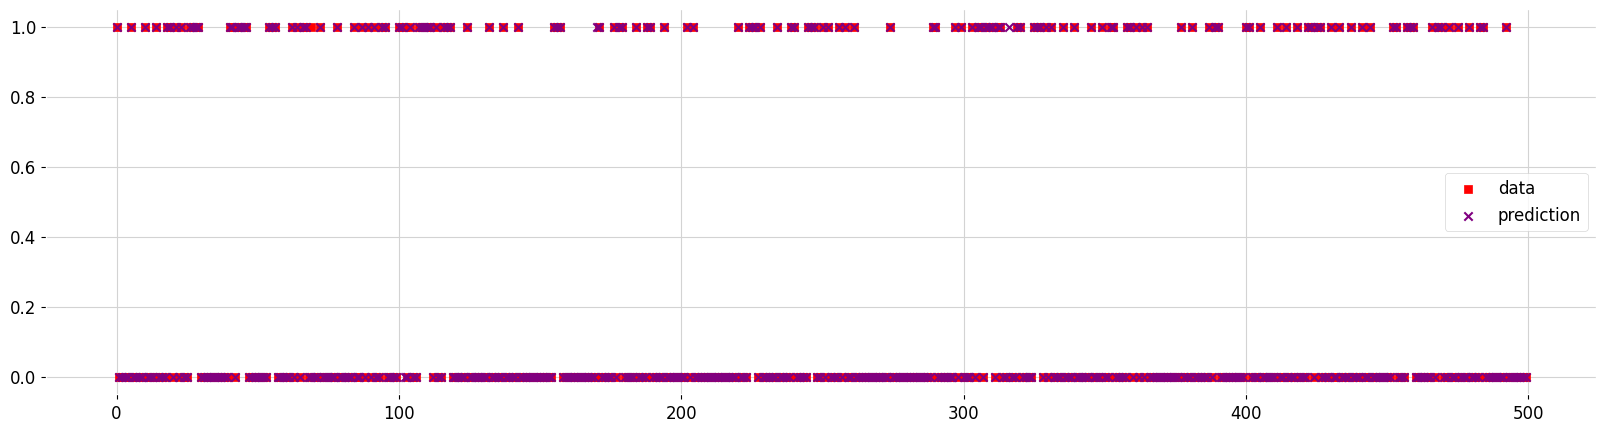

In [ ]:
# @title метрики

y_test = test_df["cheat"].tolist()
predictions = clf.predict(test_df[tags])

rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)
pr = precision_score(y_true=test_df["cheat"], y_pred=clf.predict(test_df[tags]))
rec = recall_score(y_true=test_df["cheat"],y_pred=clf.predict(test_df[tags]))

print('Precision:', pr)
print('Recall:', rec)
print("RMSE:", rmse)
print("R2:", r2)

plt.scatter(range(0,len(predictions)),test_df['cheat'], marker='s', c='r')
plt.scatter(range(0,len(predictions)), predictions, marker='x', c='purple')
plt.legend (('data','prediction' ))
plt.show()

In [ ]:
# @title Экспорт модели
ref_cols = tags
model = clf
target = 'cheat'
joblib.dump(value=[model , ref_cols, target], filename="./model/model.pkl")

['./model/model.pkl']

# Предсказание значений

In [ ]:
temp = pd.DataFrame(clf.predict_proba(inpData[tags]).tolist(), columns = clf.classes_)
prob_list = temp[1].tolist()

profileCheatProb = round( sum(prob_list)/len(prob_list) , 2)
prob_list = [profileCheatProb] + prob_list

prob_list #первое значение вероятность читерства в сессии дней, далее вероятность читерства в каждом дне

[0.98, 0.96, 0.99, 0.96, 1.0, 0.97, 1.0]

In [ ]:
!ls

data  gdrive  model  sample_data
